- Labels in this dataset:
    - 0: helmet
    - 1: LP
    - 2: no helmet


- More info:
    - Number of classes: 3
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

In [2]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-91f074d5-10b9-84d7-e00c-cb1444b1ac93)
GPU 1: Tesla T4 (UUID: GPU-c8b5d963-4b52-62d0-c1d1-870bab2c5e5e)


# Installs/Imports

In [3]:
! pip install --upgrade ultralytics -qq


In [4]:
import ultralytics
print(ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
8.3.40


In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import torch

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [6]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [7]:
class CFG:
    SEED = 1
    # classes
    NUM_CLASSES = 3
    CLASSES = ['helmet', 'LP', 'no helmet']

    # training
    EPOCHS = 200 
    BATCH_SIZE = 32
    
    BASE_MODEL = 'yolov10n' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 0.001
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/helmet-detection-v3i'
    OUTPUT_DIR = '/kaggle/working/'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [8]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [9]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- helmet
- LP
- no helmet
nc: 3
test: /kaggle/input/helmet-detection-v3i/test
train: /kaggle/input/helmet-detection-v3i/train
val: /kaggle/input/helmet-detection-v3i/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



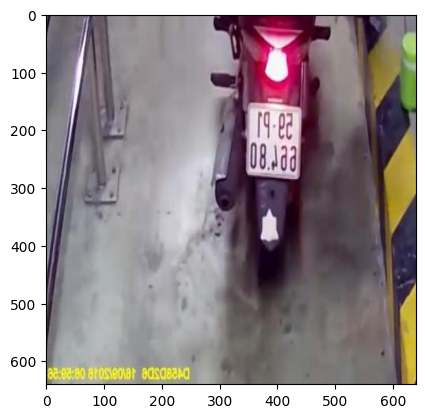

In [10]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()
    
example_image_path = '/kaggle/input/helmet-detection-v3i/train/images/0000_00532_b_jpg.rf.167dacb99fb3d649ecb65ac8fecf5978.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

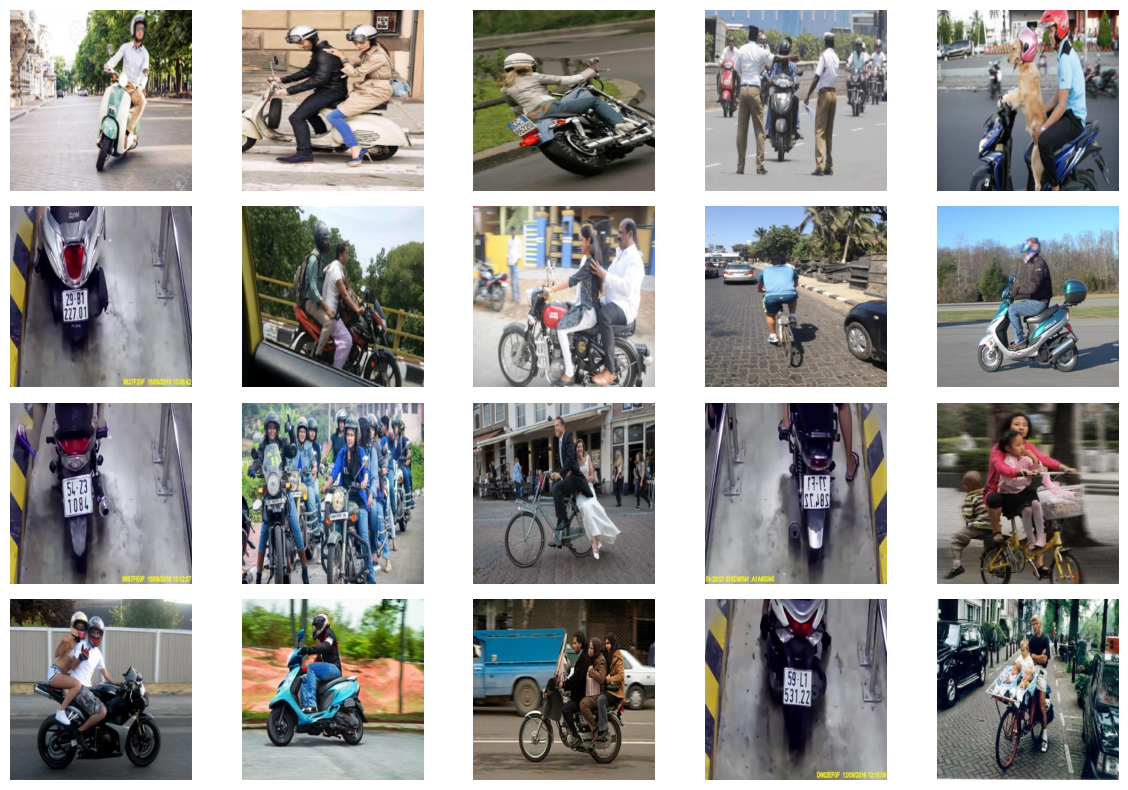

In [11]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()
    
folder_path = CFG.CUSTOM_DATASET_DIR + '/train/images/'
# folder_path = '/kaggle/input/helmet-lincense-plate-detection/train/images'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

## Image properties

In [12]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [13]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 121 ms, sys: 148 ms, total: 270 ms
Wall time: 11.7 s


Mode  helmet   LP  no helmet  Data_Volume
0  train     847  521        525         1528
1  valid      97   56         52          161
2   test      40   20         37           80

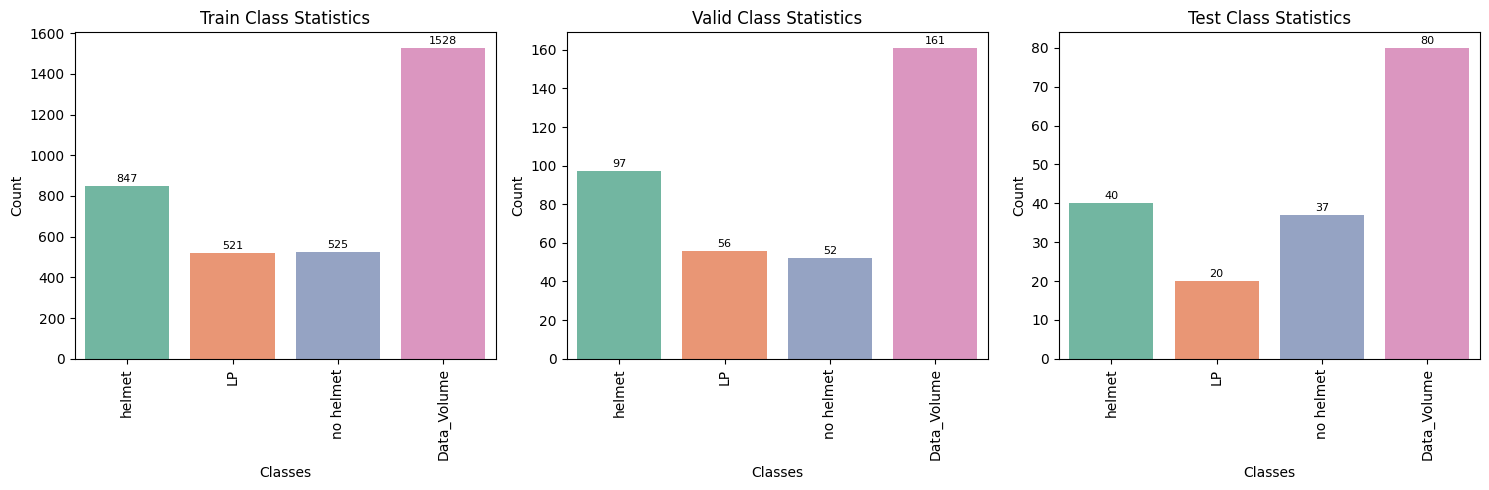

In [14]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [15]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

100%|██████████| 5.59M/5.59M [00:00<00:00, 72.6MB/s]


In [16]:
!pip install -U ipywidgets

In [17]:
# import torch
# torch.cuda.empty_cache()
# cuda_available = torch.cuda.is_available()
# print(cuda_available)

In [ ]:
results = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    imgsz = (img_properties['height'], img_properties['width']),
    seed = CFG.SEED,
    device = [0,1], #[0,1], # 0
    workers=4,
    name='yolov10n_HelmetDetection')

Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolov10n.pt, data=/kaggle/working/data.yaml, epochs=200, time=None, patience=100, batch=32, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=[0, 1], workers=4, project=None, name=yolov10n_HelmetDetection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fals

train: Scanning /kaggle/input/helmet-detection-v3i/train/labels... 1528 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1528/1528 [00:02<00:00, 582.84it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/helmet-detection-v3i/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/helmet-detection-v3i/valid/labels... 161 images, 0 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<00:00, 405.74it/s]/s]
train: Scanning /kaggle/input/helmet-detection-v3i/train/labels... 309 images, 0 backgrounds, 0 corrupt:  20%|██        | 309/1528 [00:00<00:02, 559.45it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/helmet-detection-v3i/valid is not writeable, cache not saved.


train: Scanning /kaggle/input/helmet-detection-v3i/train/labels... 1130 images, 0 backgrounds, 0 corrupt:  74%|███████▍  | 1130/1528 [00:02<00:00, 603.11it/s]

Plotting labels to runs/detect/yolov10n_HelmetDetection/labels.jpg... 


train: Scanning /kaggle/input/helmet-detection-v3i/train/labels... 1528 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1528/1528 [00:02<00:00, 550.02it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov10n_HelmetDetection
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.08G      2.703      8.741      2.403         64        640: 100%|██████████| 48/48 [00:36<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


                   all        161        397    0.00775      0.806      0.247      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.01G      2.533       6.04      2.237         33        640: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


                   all        161        397      0.835      0.294      0.499      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.99G      2.476      5.277       2.24         41        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


                   all        161        397      0.568      0.523      0.548      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.01G      2.588      4.556      2.273         56        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


                   all        161        397      0.572       0.51      0.519      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.02G      2.413      4.139      2.228         58        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


                   all        161        397      0.446      0.471      0.339      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.01G       2.47      3.592      2.227         19        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


                   all        161        397      0.622      0.561      0.629      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.02G      2.427      3.177      2.194         39        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


                   all        161        397      0.682      0.557      0.658      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.01G      2.282      2.883      2.192         34        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


                   all        161        397      0.723       0.61      0.699      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.01G      2.272      2.622      2.188         41        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


                   all        161        397      0.676      0.638      0.675       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.01G      2.319      2.488      2.199         45        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


                   all        161        397      0.651      0.651      0.696      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.99G      2.275      2.316      2.157         45        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


                   all        161        397       0.76      0.695      0.769      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.04G      2.259      2.184      2.163         23        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


                   all        161        397      0.668      0.681      0.699      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.01G      2.164      2.042      2.136         36        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


                   all        161        397      0.742      0.679      0.735       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.06G      2.314      2.086      2.167         63        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


                   all        161        397      0.662      0.723      0.741      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.06G       2.22      1.938      2.136         52        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


                   all        161        397      0.759      0.713      0.737      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.99G      2.146      1.877      2.102         23        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


                   all        161        397      0.781      0.684      0.766      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.13G      2.232      1.871      2.115         66        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


                   all        161        397      0.718      0.724      0.757      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.02G      2.052      1.685      2.086         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


                   all        161        397      0.696      0.761      0.765      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.02G      2.042      1.682      2.073         50        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


                   all        161        397       0.78      0.742      0.781       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.03G      2.029      1.602      2.045         34        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


                   all        161        397      0.759      0.726      0.766      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.01G      2.021      1.588       2.05         44        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


                   all        161        397      0.808      0.729       0.79      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.01G      1.965      1.556      2.068         24        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


                   all        161        397      0.719      0.732      0.755      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.01G      2.018       1.57      2.073         29        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


                   all        161        397      0.794      0.716       0.76      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.02G      1.996      1.522      2.056         39        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


                   all        161        397      0.754      0.765      0.797      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.11G      1.958      1.469      2.023         56        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


                   all        161        397      0.763      0.761      0.785      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.01G      1.918      1.445       2.01         24        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


                   all        161        397      0.794      0.729      0.795      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.01G      1.933      1.393      2.031         32        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


                   all        161        397      0.817      0.758      0.785      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.99G      1.897      1.389      1.999         58        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


                   all        161        397      0.789      0.769      0.795      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.01G      1.877      1.366          2         39        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


                   all        161        397      0.771      0.784        0.8      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.01G      1.877      1.319      2.014         44        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


                   all        161        397      0.816      0.774      0.806      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.02G      1.891       1.35      1.986         45        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


                   all        161        397      0.782      0.736      0.783      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.03G      1.916      1.355       1.99         50        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


                   all        161        397      0.794      0.807      0.821      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.01G      1.857      1.304      1.989         51        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


                   all        161        397      0.847      0.747      0.806      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.04G      1.836      1.274      1.972         45        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


                   all        161        397      0.745      0.758      0.769      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.01G       1.85      1.305      1.963         35        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


                   all        161        397      0.786      0.782      0.804      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.01G      1.796      1.215      1.963         69        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


                   all        161        397      0.809      0.775      0.802      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.01G      1.777      1.181      1.954         43        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


                   all        161        397      0.801      0.807      0.818      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.02G      1.818      1.193      1.978         45        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


                   all        161        397      0.803      0.764       0.78      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.12G      1.787       1.23      1.954         57        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.67it/s]


                   all        161        397      0.818      0.783      0.817      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.01G      1.745      1.189      1.957         52        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


                   all        161        397      0.822      0.775      0.812      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.01G      1.736      1.203      1.957         51        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


                   all        161        397      0.827      0.766      0.814      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.02G      1.738      1.169      1.978         49        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


                   all        161        397      0.787      0.755      0.775      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.01G      1.752      1.169      1.946         19        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


                   all        161        397       0.82      0.765       0.79      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.01G      1.752      1.178      1.952         48        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


                   all        161        397      0.821      0.784      0.828      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.01G      1.679      1.149      1.915         31        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


                   all        161        397      0.803      0.791      0.807      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.01G      1.713      1.161      1.922         39        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


                   all        161        397      0.825      0.739      0.787       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.01G      1.686      1.135      1.924         41        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


                   all        161        397      0.848      0.766      0.797      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.01G      1.662       1.11      1.933         40        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


                   all        161        397      0.811       0.76      0.798      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.04G      1.727      1.138      1.936         40        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


                   all        161        397      0.793      0.782      0.807      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.01G      1.681      1.131      1.897         34        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


                   all        161        397      0.855      0.752      0.809      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200         3G      1.644      1.071      1.903         37        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


                   all        161        397      0.812      0.778      0.803      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.01G      1.639      1.085      1.895         31        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


                   all        161        397      0.806      0.771      0.807      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.99G      1.587       1.01      1.895         43        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


                   all        161        397      0.837      0.782      0.831      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.02G      1.657      1.057      1.915         53        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


                   all        161        397      0.838      0.751      0.815      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.06G      1.598      1.062      1.893         48        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


                   all        161        397      0.833      0.797      0.817      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.99G       1.53     0.9509      1.875         44        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


                   all        161        397      0.821      0.799       0.83      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.01G      1.586      1.015      1.875         75        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.63it/s]


                   all        161        397      0.816      0.805      0.832      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.02G      1.485     0.9714      1.854         42        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


                   all        161        397      0.808      0.767      0.801      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.01G      1.568      1.021      1.864         43        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


                   all        161        397      0.823       0.79      0.822      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.04G      1.524     0.9806      1.902         31        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


                   all        161        397      0.847      0.754      0.812      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.01G       1.57      1.002      1.873         53        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


                   all        161        397      0.814      0.723      0.763       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.09G      1.529     0.9717      1.862         45        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


                   all        161        397       0.79      0.772      0.801      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200         3G      1.545     0.9913      1.875         43        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


                   all        161        397      0.858      0.748       0.82      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.01G       1.49      0.964       1.85         44        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


                   all        161        397      0.841      0.765      0.809      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.02G      1.472     0.9246      1.851         35        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


                   all        161        397      0.852      0.807      0.828      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.01G       1.47     0.9303       1.84         25        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


                   all        161        397      0.799       0.79      0.793       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.02G      1.465     0.9379      1.863         71        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


                   all        161        397      0.826      0.756      0.795      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.01G      1.507     0.9998       1.87         34        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


                   all        161        397      0.833      0.781      0.831      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.01G      1.404     0.8869      1.835         28        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


                   all        161        397      0.822       0.78      0.811      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.05G      1.488     0.9147       1.84         31        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


                   all        161        397      0.848      0.779      0.817      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.01G      1.473     0.9495      1.846         42        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


                   all        161        397      0.805      0.767      0.814      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.05G      1.436     0.8897      1.824         46        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


                   all        161        397      0.816      0.808      0.838      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200         3G      1.414     0.8574       1.83         59        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


                   all        161        397      0.857      0.774      0.821      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.01G      1.416     0.8731       1.84         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


                   all        161        397      0.847      0.757      0.806      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.99G      1.428     0.9245      1.842         47        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


                   all        161        397       0.85      0.757      0.829      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.14G      1.427     0.8845      1.819         35        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


                   all        161        397      0.845       0.78      0.809       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.01G      1.399     0.8881      1.836         29        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


                   all        161        397       0.81      0.812       0.81      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.01G      1.417     0.8964      1.813         47        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


                   all        161        397      0.854      0.757      0.812      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      3.01G      1.377     0.8809      1.807         35        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


                   all        161        397      0.841      0.777      0.815      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.04G      1.414     0.8887      1.828         64        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.67it/s]


                   all        161        397      0.872      0.731      0.817      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      3.01G      1.331     0.8477      1.823         28        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


                   all        161        397      0.816       0.78      0.816      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      3.01G      1.386     0.8776      1.832         43        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


                   all        161        397      0.814      0.805      0.823      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.06G      1.432     0.9513      1.825         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


                   all        161        397      0.818      0.777      0.805      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      3.01G      1.378      0.856      1.828         27        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


                   all        161        397      0.831      0.814      0.828      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.01G      1.374     0.8477      1.825         32        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


                   all        161        397      0.835      0.778       0.81      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      3.08G      1.332     0.8368      1.825         41        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


                   all        161        397      0.806      0.805       0.82      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      3.01G      1.338     0.8201      1.798         52        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


                   all        161        397      0.838      0.802      0.821      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      3.01G      1.339     0.8191      1.801         60        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


                   all        161        397      0.808      0.813      0.823      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.02G      1.343     0.8356      1.813         35        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


                   all        161        397      0.821      0.787      0.811      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      3.01G      1.374     0.8156      1.793         60        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


                   all        161        397       0.85      0.749      0.814      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.02G      1.269     0.7775      1.802         30        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


                   all        161        397      0.796       0.78      0.807      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      3.01G      1.311        0.8       1.79         44        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


                   all        161        397       0.89      0.738      0.817       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      3.07G      1.293     0.7929      1.796         40        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


                   all        161        397      0.812      0.766      0.806      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      3.01G      1.292     0.7925       1.79         44        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


                   all        161        397      0.818      0.798      0.829      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      3.01G       1.33     0.8029      1.803         25        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


                   all        161        397      0.845      0.779      0.817      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.04G      1.302     0.8063      1.781         17        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


                   all        161        397      0.853      0.773      0.821      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      3.01G      1.324     0.8032      1.796         32        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]


                   all        161        397      0.831      0.795      0.814      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      3.02G      1.264     0.7826      1.789         43        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


                   all        161        397      0.809      0.811      0.828      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      3.04G      1.227     0.7667      1.769         36        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


                   all        161        397      0.839      0.791      0.822      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200       3.1G      1.296     0.7895      1.793         36        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


                   all        161        397      0.851      0.786      0.834      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.98G      1.271      0.794       1.78         32        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


                   all        161        397      0.853      0.793      0.827      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      3.01G      1.249     0.7672       1.77         43        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


                   all        161        397      0.842      0.777      0.828      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200         3G      1.256     0.7673      1.787         44        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


                   all        161        397      0.838      0.801      0.835      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.11G      1.278       0.77      1.795         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


                   all        161        397       0.88      0.766      0.843       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      3.01G      1.324     0.8277      1.792         59        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


                   all        161        397       0.83      0.793      0.832      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      3.01G      1.281     0.7847      1.788         39        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


                   all        161        397      0.851      0.768      0.837       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      3.04G      1.232     0.7708      1.778         30        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


                   all        161        397      0.884       0.76       0.83      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.99G      1.235     0.7394      1.778         22        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


                   all        161        397      0.837      0.802      0.837       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      3.01G      1.186     0.7119      1.768         40        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


                   all        161        397      0.867      0.779      0.837       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      3.01G       1.18     0.7153       1.76         77        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


                   all        161        397      0.857       0.77      0.824      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      3.04G      1.225     0.7243      1.766         28        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


                   all        161        397      0.836      0.801      0.831      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.99G      1.225     0.7158      1.781         56        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


                   all        161        397      0.851      0.784      0.828       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.99G      1.269     0.7691      1.792         32        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


                   all        161        397      0.871      0.778      0.833       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      3.02G      1.237     0.7574      1.775         46        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


                   all        161        397      0.872      0.765      0.826       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.99G      1.183     0.7036      1.767         42        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


                   all        161        397      0.842      0.776      0.817      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      3.01G      1.203     0.7368      1.758         41        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


                   all        161        397      0.825      0.768      0.795      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      3.01G      1.168      0.699      1.748         67        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


                   all        161        397       0.83      0.781      0.813      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      3.01G      1.215     0.7096      1.758         44        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


                   all        161        397      0.804      0.792      0.819       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      3.01G      1.161     0.6897       1.77         33        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


                   all        161        397      0.841      0.764      0.803      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.01G      1.196     0.7508      1.766         41        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


                   all        161        397      0.851      0.745      0.798      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.01G      1.173     0.7116      1.746         26        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


                   all        161        397      0.841      0.784      0.825      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      3.01G      1.126     0.6905      1.742         45        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


                   all        161        397      0.842      0.792      0.828      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      3.05G      1.141     0.6748      1.749         49        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


                   all        161        397      0.853      0.782      0.825       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      3.01G      1.179     0.7387      1.759         36        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


                   all        161        397       0.85      0.755       0.81      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      3.01G      1.156     0.6969      1.756         37        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


                   all        161        397      0.816      0.787      0.808      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      3.04G      1.168      0.707      1.759         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


                   all        161        397      0.826      0.802      0.825      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      3.02G      1.136     0.6776      1.743         57        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


                   all        161        397      0.824      0.775      0.813      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      3.01G      1.118     0.6685      1.741         47        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


                   all        161        397       0.87      0.763      0.821      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      3.01G       1.14     0.6944      1.745         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


                   all        161        397      0.814      0.772      0.797      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200         3G      1.114      0.677      1.745         57        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


                   all        161        397      0.829      0.794       0.81      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      3.01G      1.157     0.6894      1.737         56        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


                   all        161        397      0.831      0.778      0.821      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      3.01G      1.145     0.6935      1.744         34        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


                   all        161        397      0.858      0.759      0.814      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      3.04G      1.154     0.7077      1.747         50        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


                   all        161        397      0.823      0.804      0.819      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      3.01G      1.129      0.676      1.734         46        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


                   all        161        397      0.834      0.818      0.828       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      3.01G      1.065     0.6251      1.727         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


                   all        161        397      0.857      0.784      0.815      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      3.02G      1.078     0.6533      1.734         29        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


                   all        161        397      0.842      0.789      0.829      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      3.01G      1.094     0.6681      1.733         48        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


                   all        161        397      0.831      0.803      0.833      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200         3G      1.042     0.6189      1.736         25        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.63it/s]


                   all        161        397      0.829      0.769      0.817      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.99G      1.108     0.6642      1.756         33        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


                   all        161        397      0.795      0.807      0.817      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      3.01G      1.078     0.6398      1.725         36        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


                   all        161        397      0.854      0.761      0.833      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      3.01G      1.086     0.6594      1.734         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


                   all        161        397      0.831      0.802      0.826      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.99G      1.129      0.662      1.737         23        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


                   all        161        397      0.824      0.814      0.831       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      3.02G      1.072     0.6449      1.745         36        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.64it/s]


                   all        161        397      0.851      0.787      0.831      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      3.01G       1.04     0.6244      1.725         22        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


                   all        161        397      0.806      0.802       0.82      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      3.04G      1.087      0.651      1.718         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


                   all        161        397      0.872       0.78      0.818      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      3.09G      1.075     0.6577      1.728         27        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


                   all        161        397      0.809      0.816      0.822      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      3.01G      1.033      0.639       1.73         26        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


                   all        161        397       0.81      0.826      0.831      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      3.04G       1.09     0.6599      1.737         18        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


                   all        161        397      0.877       0.76      0.832      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      3.03G      1.033     0.6424      1.737         33        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


                   all        161        397      0.805      0.825       0.83      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      3.03G      1.041     0.6184      1.713         32        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


                   all        161        397      0.845      0.773      0.823      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200         3G      1.043     0.6364      1.743         26        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


                   all        161        397      0.821      0.808      0.818      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      3.01G      1.054     0.6068      1.715         27        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


                   all        161        397      0.797      0.806      0.819      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.99G      1.024     0.5991      1.707         41        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


                   all        161        397      0.847      0.773      0.816      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      3.05G     0.9856     0.5967      1.712         30        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


                   all        161        397       0.84      0.762      0.814      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.99G       1.01     0.5925        1.7         48        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


                   all        161        397      0.814      0.807      0.821      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.99G     0.9984     0.6096      1.716         30        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


                   all        161        397      0.816      0.786      0.819       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      3.04G      1.004     0.6066      1.728         32        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


                   all        161        397      0.811      0.797      0.817      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      3.01G      1.031     0.6213      1.726         31        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


                   all        161        397      0.826      0.786      0.818      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      3.04G     0.9821     0.5876      1.689         40        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


                   all        161        397       0.82      0.795      0.818       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200         3G      1.019     0.6137      1.706         50        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


                   all        161        397       0.84      0.777      0.823      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      3.01G      0.964     0.5854      1.715         48        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


                   all        161        397      0.817      0.784      0.811      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      3.01G     0.9823     0.6007      1.708         23        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


                   all        161        397       0.83      0.779      0.825      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      3.01G      0.993       0.61      1.711         29        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


                   all        161        397      0.834      0.785      0.822      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      3.01G      1.016     0.6012      1.711         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


                   all        161        397      0.821      0.792      0.828       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.99G     0.9917     0.5825      1.703         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


                   all        161        397      0.806      0.801      0.827      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      3.01G     0.9815     0.5861      1.692         28        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


                   all        161        397      0.823      0.793      0.825      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      3.05G     0.9868     0.5871      1.709         30        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.63it/s]


                   all        161        397      0.819      0.791      0.818      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      3.02G     0.9976     0.6129      1.695         34        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


                   all        161        397      0.817      0.777      0.817      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      3.01G      0.942     0.5836      1.701         25        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


                   all        161        397      0.823      0.783      0.816      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      3.02G     0.9492     0.5637      1.705         40        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


                   all        161        397      0.839      0.787      0.823      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      3.04G     0.9652     0.5647      1.691         40        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


                   all        161        397      0.817      0.795      0.822      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      3.06G     0.9624     0.5492       1.71         51        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


                   all        161        397       0.84      0.778      0.819      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      3.04G     0.9637     0.5954      1.705         23        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


                   all        161        397      0.859      0.773       0.82      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      3.02G     0.9631     0.5743      1.703         38        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


                   all        161        397      0.864      0.772      0.827      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      3.05G     0.9552     0.5708      1.691         60        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


                   all        161        397      0.867      0.745      0.819      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      3.01G     0.9826     0.5938       1.71         48        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


                   all        161        397      0.835      0.773      0.816      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      3.03G      0.952     0.5734      1.692         24        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]


                   all        161        397      0.806      0.803       0.82      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      3.01G     0.9461     0.5728      1.688         41        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


                   all        161        397      0.856      0.766      0.813      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200         3G     0.9243     0.5436      1.676         35        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


                   all        161        397       0.82       0.77      0.819      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200         3G     0.9298      0.556      1.689         69        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


                   all        161        397      0.858      0.756      0.821       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      3.03G     0.9155     0.5372      1.707         28        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


                   all        161        397      0.853      0.768      0.828      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      3.01G     0.9438     0.5597      1.687         55        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


                   all        161        397      0.858      0.766      0.823      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      3.01G     0.9007     0.5384      1.684         75        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


                   all        161        397      0.845       0.76      0.819       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      3.01G     0.9131     0.5478      1.698         40        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


                   all        161        397      0.858      0.754       0.82      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      3.01G     0.9157     0.5681      1.715         33        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


                   all        161        397      0.838      0.769       0.82      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      3.01G     0.8917     0.5375      1.688         36        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.63it/s]


                   all        161        397      0.834      0.778      0.825      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      3.04G     0.8932     0.5481      1.685         60        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


                   all        161        397      0.816      0.796      0.825      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      3.02G     0.8801     0.5356      1.691         43        640: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.63it/s]


                   all        161        397      0.866      0.761      0.831      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      3.09G      0.894     0.5495      1.699         81        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


                   all        161        397      0.825      0.777      0.822      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.99G     0.8936     0.5402      1.691         49        640: 100%|██████████| 48/48 [00:34<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


                   all        161        397       0.79      0.798      0.818      0.585
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      3.09G      0.792     0.4393      1.647         25        640: 100%|██████████| 48/48 [00:35<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


                   all        161        397      0.847      0.759      0.816       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      3.09G     0.7553     0.4197      1.646         26        640: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


                   all        161        397       0.85      0.772       0.82       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.99G     0.7532     0.4068      1.648         16        640: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


                   all        161        397       0.84      0.776      0.823      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.99G      0.799     0.4388      1.654         14        640: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


                   all        161        397      0.834      0.781       0.82       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      3.01G     0.7793     0.4415      1.631         20        640: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]


                   all        161        397      0.862      0.753      0.821      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.99G     0.7572     0.4217      1.638         21        640: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


                   all        161        397      0.832      0.778      0.819      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.99G     0.7554     0.4168      1.636         21        640: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


                   all        161        397      0.839      0.778      0.817      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      3.01G     0.7569     0.4212      1.642         16        640: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


                   all        161        397      0.839      0.771      0.815      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      3.01G     0.7775      0.442      1.645         25        640: 100%|██████████| 48/48 [00:35<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


                   all        161        397      0.855       0.76      0.818       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.99G     0.7008     0.4074      1.628         28        640: 100%|██████████| 48/48 [00:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


                   all        161        397      0.873      0.759      0.818      0.579

200 epochs completed in 2.038 hours.
Optimizer stripped from runs/detect/yolov10n_HelmetDetection/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/yolov10n_HelmetDetection/weights/best.pt, 5.8MB

Validating runs/detect/yolov10n_HelmetDetection/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


                   all        161        397      0.854      0.762      0.833      0.591
                helmet         97        232      0.791      0.782      0.827      0.578
                    LP         56         56      0.976          1      0.995      0.874
             no helmet         52        109      0.796      0.502      0.678      0.321
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/yolov10n_HelmetDetection


# Export

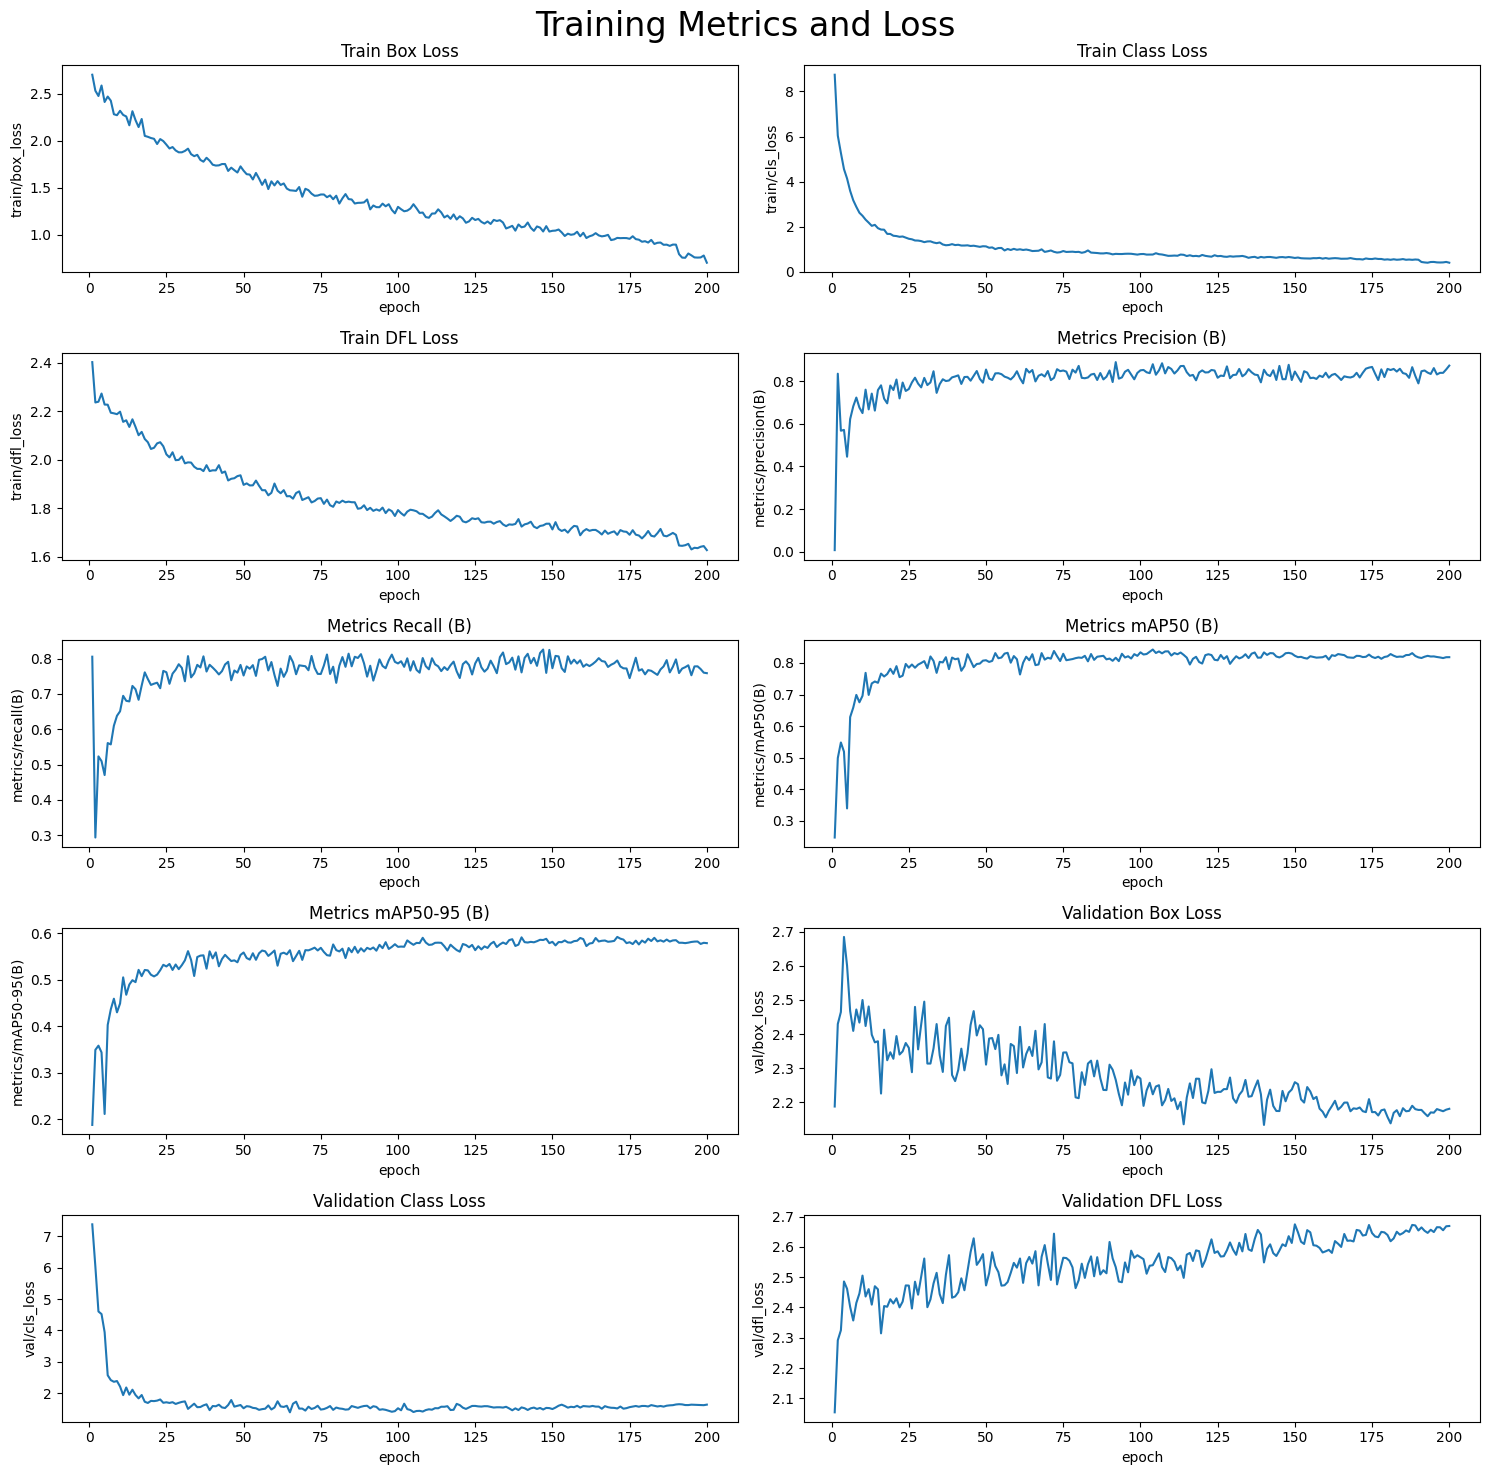

In [21]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov10n_HelmetDetection/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Evaluation

In [22]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/yolov10n_HelmetDetection/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /kaggle/input/helmet-detection-v3i/test/labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 227.11it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/helmet-detection-v3i/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


                   all         80        193      0.891       0.81      0.859      0.663
                helmet         40         88      0.865      0.886       0.91      0.751
                    LP         20         20          1       0.95      0.975      0.847
             no helmet         37         85      0.808      0.594      0.693      0.392
Speed: 0.3ms preprocess, 6.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val


In [23]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.6632460109858713
Mean Average Precision @ .50   : 0.8591614035295002
Mean Average Precision @ .70   : 0.7231653755631999


# Test model



image 1/80 /kaggle/input/helmet-detection-v3i/test/images/0445_05932_b_jpg.rf.ab4cda766333faf5d9118d6820c499cf.jpg: 640x640 1 LP, 10.2ms
image 2/80 /kaggle/input/helmet-detection-v3i/test/images/0502_05240_b_jpg.rf.a2b24870cec0f1358ce87888f39ae6e3.jpg: 640x640 1 LP, 10.3ms
image 3/80 /kaggle/input/helmet-detection-v3i/test/images/0502_06701_b_jpg.rf.d449e4137d34db82b25e7f992d6309d9.jpg: 640x640 1 LP, 10.3ms
image 4/80 /kaggle/input/helmet-detection-v3i/test/images/0504_06601_b_jpg.rf.3d09ba6734d4bb565071ae7a29ccfbf7.jpg: 640x640 1 LP, 10.4ms
image 5/80 /kaggle/input/helmet-detection-v3i/test/images/0505_04736_b_jpg.rf.d3413122b4254f3770f42e8368d7ec5f.jpg: 640x640 1 LP, 9.4ms
image 6/80 /kaggle/input/helmet-detection-v3i/test/images/0506_06676_b_jpg.rf.28780e918df57c0f83c709fea4d40df7.jpg: 640x640 1 LP, 10.0ms
image 7/80 /kaggle/input/helmet-detection-v3i/test/images/0508_06228_b_jpg.rf.cf5cb78dd3bf25bb297723233113b39d.jpg: 640x640 1 LP, 9.7ms
image 8/80 /kaggle/input/helmet-detection-

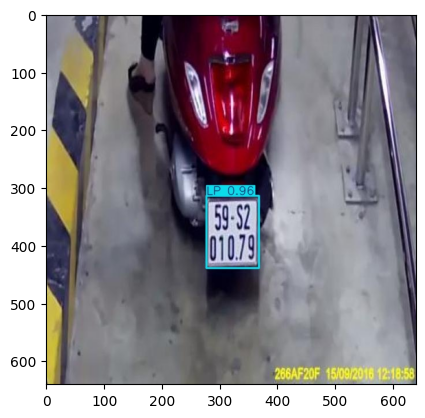

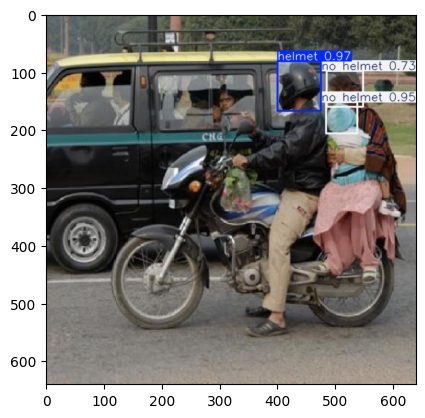

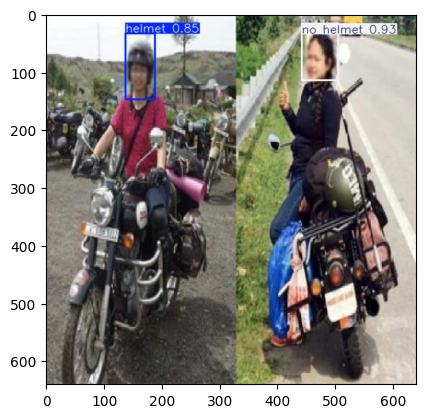

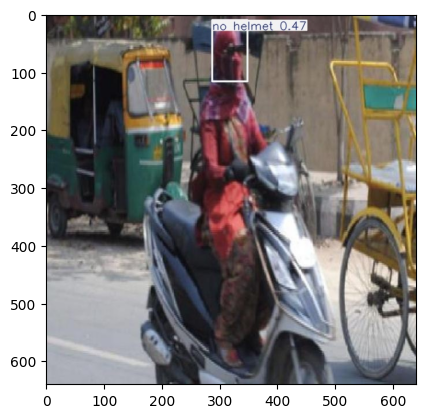

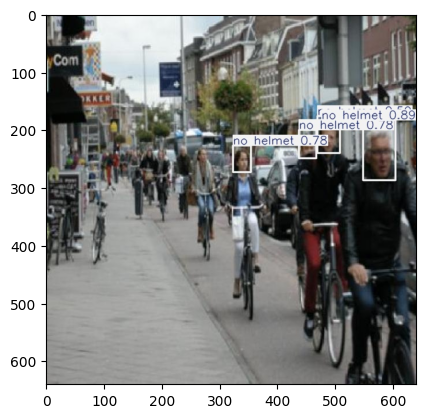

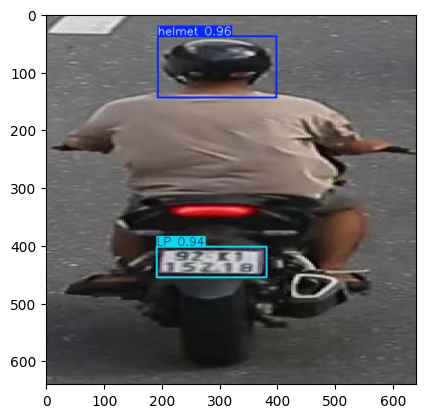

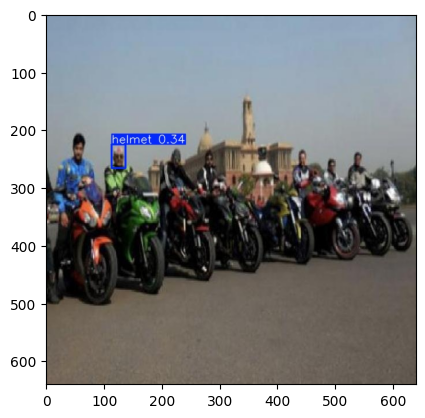

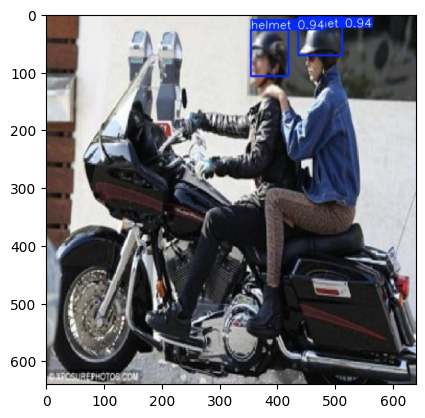

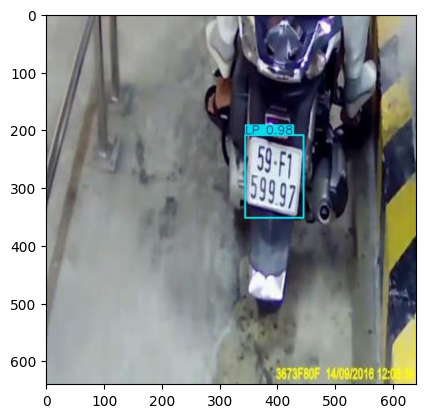

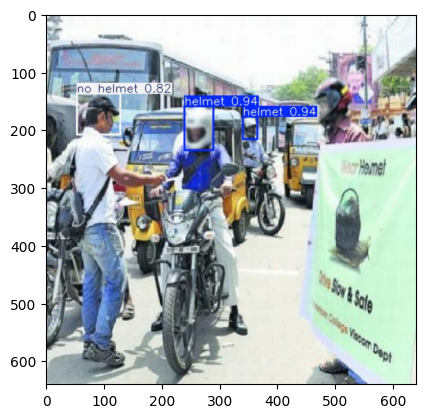

In [24]:
results = model.predict(source=os.path.join(CFG.CUSTOM_DATASET_DIR, 'test', 'images'), save=True)
%matplotlib inline

predicitions = glob.glob(os.path.join(CFG.OUTPUT_DIR, 'runs/detect/predict', '*'))

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()

In [25]:
!zip -r output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/predict/ (stored 0%)
  adding: kaggle/working/runs/detect/predict/0519_08310_b_jpg.rf.f6ea8091a20abb35fddb8d059ec24203.jpg (deflated 5%)
  adding: kaggle/working/runs/detect/predict/BikesHelmets173_png_jpg.rf.ce2f53293070fc617846f3cbdfc1dabf.jpg (deflated 4%)
  adding: kaggle/working/runs/detect/predict/0445_05932_b_jpg.rf.ab4cda766333faf5d9118d6820c499cf.jpg (deflated 5%)
  adding: kaggle/working/runs/detect/predict/BikesHelmets618_png_jpg.rf.746c0ff39153d8b1a597fd3db7a82566.jpg (deflated 3%)
  adding: kaggle/working/runs/detect/predict/BikesHelmets1_png_jpg.rf.dbe684393f7612c72f616f4065249e00.jpg (deflated 4%)
  adding: kaggle/working/runs/detect/predict/im547_jpg.rf.169fa2cf9fdf4912e7ac5b8dc3005ad8.jpg (deflated 5%)
  adding: kaggle/working/runs/detect/predict/im395_jpg.rf.493bd2571eb67dbe74b24684dcddf759.jpg (deflate

In [ ]:
# !zip -r output.zip /kaggle/working/
# !rm -rf /kaggle/working/runs